<font size="6"> **Donwload SEC 10-K Fillings** </font>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%run ../nb_config.py

In [5]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import pprint

import os

from tqdm import tqdm

In [8]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [37]:
cfg = utils.read_conf()

In [53]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_10k', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [55]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'sec_10k.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 = cfg['quantopian']['dataset4']['prices']

In [133]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_10k', '')
os.path.isdir(OUTPATH)

True

In [134]:
OUTFILE = 'sec_10k_cos_similarities.csv'

# Load SEC 10-K Processed fillings

In [12]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [13]:
with open(INPATH1 + INFILE2, 'rb') as file:
    ten_ks_by_ticker = pickle.load(file)

In [14]:
example_ticker = 'AMZN'

In [16]:
file_dates = metadata['file_dates']

In [ ]:
sentiment_df =  pd.read_csv(OUTPATH + INFILE3)

In [60]:
# Yearly pricing
pricing = pd.read_csv(INPATH2 + INFILE4, parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')
pricing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [62]:
pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


# Compute Document Sentiment

In [17]:
ten_ks_by_ticker['AMZN'][0].keys()

dict_keys(['cik', 'file', 'file_date', 'file_clean', 'file_lemma'])

In [18]:
sentiment_df.columns

Index(['negative', 'positive', 'uncertainty', 'litigious', 'constraining',
       'interesting', 'word'],
      dtype='object')

In [19]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [20]:
ten_ks_by_ticker[example_ticker][0]['file_date'], ten_ks_by_ticker[example_ticker][-1]['file_date']

('2017-02-10', '1999-03-05')

In [21]:
file_dates[example_ticker][0], file_dates[example_ticker][-1]

('2017-02-10', '1999-03-05')

## Sentiment BoW and TF-IDF Representations

In [22]:
sentiment_bow_ten_ks = {}
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    sentiment_bow_ten_ks[ticker] = {}
    sentiment_tfidf_ten_ks[ticker] = {}
    for sentiment in sentiments:
        sentiment_vocab = sentiment_df[sentiment_df[sentiment]]['word']
        sentiment_bow_ten_ks[ticker][sentiment] = bow_sent.get_bag_of_words(sentiment_vocab, lemma_docs)
        sentiment_tfidf_ten_ks[ticker][sentiment] = bow_sent.get_tfidf(sentiment_vocab, lemma_docs)

In [23]:
sentiment_bow_ten_ks[example_ticker]['litigious'].shape  # N_docs, vocab_size

(17, 716)

In [24]:
sentiment_bow_ten_ks[example_ticker]['negative'].shape  # N_docs, vocab_size

(17, 1515)

## Compute Similarities

For each sentiment, starting off from the first document, compute sequential distances dist(doc[t], doc[t+1])

In [25]:
jaccard_similarities =  { # dict{ticker: {sentiment_word: [jac_scores]}}
    ticker: {
        sentiment_name: bow_sent.get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()
            }
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()
    }

In [26]:
cosine_similarities = {
    ticker: {
        sentiment_name: bow_sent.get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


In [27]:
jaccard_similarities[example_ticker]['litigious'][:5]

[0.9242424242424242,
 0.9696969696969697,
 0.9285714285714286,
 0.8933333333333333,
 0.8571428571428571]

In [28]:
len(jaccard_similarities[example_ticker])  # N_sentiments

6

In [29]:
len(jaccard_similarities[example_ticker]['litigious'])  # N_docs = N_dates

16

In [30]:
cosine_similarities[example_ticker]['litigious'][:5]

[0.9873617651579193,
 0.9816376738333554,
 0.985114567304071,
 0.975604010054072,
 0.9777154731676194]

In [76]:
def build_distances_df(dict_to_df):
    cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


    for ticker, ten_k_sentiments in cosine_similarities.items():
        for sentiment_name, sentiment_values in ten_k_sentiments.items():
            for sentiment_values, sentiment_value in enumerate(sentiment_values):
                cosine_similarities_df_dict['ticker'].append(ticker)
                cosine_similarities_df_dict['sentiment'].append(sentiment_name)
                cosine_similarities_df_dict['value'].append(sentiment_value)
                cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

    cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
    cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
    cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')
    
    cosine_similarities_df.index.freq = None
    
    return cosine_similarities_df

In [85]:
jaccard_similarities_df = build_distances_df(jaccard_similarities)
cosine_similarities_df = build_distances_df(cosine_similarities)

In [86]:
cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.980651
1,2015-01-01,AMZN,negative,0.959517
2,2014-01-01,AMZN,negative,0.988386
3,2013-01-01,AMZN,negative,0.974724
4,2012-01-01,AMZN,negative,0.975851


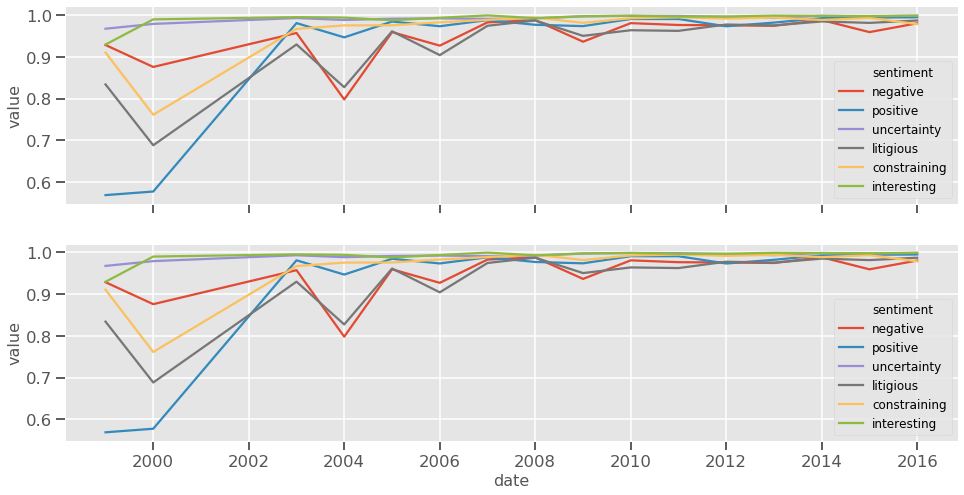

In [79]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True)

sns.lineplot(ax=axs[0], data=cosine_similarities_df[jaccard_similarities_df['ticker']==example_ticker],
             x='date', y='value', hue='sentiment')

sns.lineplot(ax=axs[1], data=cosine_similarities_df[cosine_similarities_df['ticker']==example_ticker],
             x='date', y='value', hue='sentiment')

plt.show()

In [136]:
cosine_similarities_df.to_csv(OUTPATH + OUTFILE, index=False)